In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
import csv

from torchvision import transforms
import cv2
import torch
import torch.nn as nn
import torch.nn.functional
import torchvision

import math

# swin UNet

In [2]:
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size[0], window_size[0], W // window_size[1], window_size[1], C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0], window_size[1], C)
    return windows

def window_reverse(windows, window_size, H, W):
    C = windows.shape[-1]
    x = windows.view(-1, H // window_size[0], W // window_size[1], window_size[0], window_size[1], C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, H, W, C)
    return x

def get_relative_position_index(win_h: int, win_w: int):
    # get pair-wise relative position index for each token inside the window
    coords = torch.stack(torch.meshgrid(torch.arange(win_h), torch.arange(win_w),indexing='ij'))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += win_h - 1  # shift to start from 0
    relative_coords[:, :, 1] += win_w - 1
    relative_coords[:, :, 0] *= 2 * win_w - 1
    return relative_coords.sum(-1)  # Wh*Ww, Wh*Ww

class WindowAttention(nn.Module):
    def __init__(
            self,
            dim,
            window_size,
    ):
        super().__init__()
        self.window_size = window_size
        self.window_area = self.window_size[0]*self.window_size[1]
        self.num_heads = 4
        head_dim =  dim // self.num_heads
        # attn_dim = head_dim * self.num_heads
        self.scale = head_dim ** -0.5

        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) **2, self.num_heads))

        # get pair-wise relative position index for each token inside the window
        self.register_buffer("relative_position_index", get_relative_position_index(self.window_size[0], self.window_size[1]), persistent=False)

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        torch.nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def _get_rel_pos_bias(self):
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)].view(self.window_area, self.window_area, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        return relative_position_bias.unsqueeze(0)

    def forward(self, x, mask = None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)


        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn + self._get_rel_pos_bias()
        if mask is not None:
            num_win = mask.shape[0]
            attn = attn.view(-1, num_win, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
        attn = self.softmax(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B_, N, -1)
        x = self.proj(x)
        return x

class SwinTransformerBlock(nn.Module):
    def __init__(
            self,  dim, input_resolution, window_size = 7, shift_size = 0):

        super().__init__()
        self.input_resolution = input_resolution
        window_size = (window_size, window_size)
        shift_size = (shift_size, shift_size)
        self.window_size = window_size
        self.shift_size = shift_size
        self.window_area = self.window_size[0] * self.window_size[1]

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
        )

        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.LayerNorm(4 * dim),
            nn.Linear( 4 * dim, dim)
        )

        if self.shift_size:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            H = math.ceil(H / self.window_size[0]) * self.window_size[0]
            W = math.ceil(W / self.window_size[1]) * self.window_size[1]
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            cnt = 0
            for h in (
                    slice(0, -self.window_size[0]),
                    slice(-self.window_size[0], -self.shift_size[0]),
                    slice(-self.shift_size[0], None)):
                for w in (
                        slice(0, -self.window_size[1]),
                        slice(-self.window_size[1], -self.shift_size[1]),
                        slice(-self.shift_size[1], None)):
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_area)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask, persistent=False)

    def _attn(self, x):
        B, H, W, C = x.shape

        # cyclic shift
        if self.shift_size:
            shifted_x = torch.roll(x, shifts=(-self.shift_size[0], -self.shift_size[1]), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_area, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size[0], self.window_size[1], C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
        shifted_x = shifted_x[:, :H, :W, :].contiguous()

        # reverse cyclic shift
        if self.shift_size:
            x = torch.roll(shifted_x, shifts=self.shift_size, dims=(1, 2))
        else:
            x = shifted_x
        return x

    def forward(self, x):
        B, H, W, C = x.shape
        B, H, W, C = x.shape
        x = x + self._attn(self.norm1(x))
        x = x.reshape(B, -1, C)
        x = x + self.mlp(self.norm2(x))
        x = x.reshape(B, H,W, C)
        return x


class PatchEmbedding(nn.Module):
    def __init__(self, in_ch, num_feat, patch_size):
        super().__init__()
        self.conv = nn.Conv2d(in_ch,num_feat, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).permute(0,2,3,1)

class PatchMerging(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(4 * dim)
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.reshape(B, H // 2, 2, W // 2, 2, C).permute(0, 1, 3, 4, 2, 5).flatten(3)
        x = self.norm(x)
        x = self.reduction(x)
        return x

class PatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim//2)
        self.expand = nn.Linear(dim, 2*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 2, 2, C//4)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*2, W*2 , C//4)

        x = self.norm(x)
        return x

class FinalPatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.expand = nn.Linear(dim, 16*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 4, 4, C//16)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*4, W*4 , C//16)

        x = self.norm(x)
        return x
    
class SwinBlock(nn.Module):
    def __init__(self, dims, ip_res, ss_size = 3):
        super().__init__()
        self.swtb1 = SwinTransformerBlock(dim=dims, input_resolution=ip_res)
        self.swtb2 = SwinTransformerBlock(dim=dims, input_resolution=ip_res, shift_size=ss_size)

    def forward(self, x):
        return self.swtb2(self.swtb1(x))


class Encoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.enc_swin_blocks = nn.ModuleList([
            SwinBlock(C, (H, W)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(4*C, (H//4, W//4))
        ])
        self.enc_patch_merge_blocks = nn.ModuleList([
            PatchMerging(C),
            PatchMerging(2*C),
            PatchMerging(4*C)
        ])

    def forward(self, x):
        skip_conn_ftrs = []
        for swin_block,patch_merger in zip(self.enc_swin_blocks, self.enc_patch_merge_blocks):
            x = swin_block(x)
            skip_conn_ftrs.append(x)
            x = patch_merger(x)
        return x, skip_conn_ftrs


class Decoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.dec_swin_blocks = nn.ModuleList([
            SwinBlock(4*C, (H//4, W//4)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(C, (H, W))
        ])
        self.dec_patch_expand_blocks = nn.ModuleList([
            PatchExpansion(8*C),
            PatchExpansion(4*C),
            PatchExpansion(2*C)
        ])
        self.skip_conn_concat = nn.ModuleList([
            nn.Linear(8*C, 4*C),
            nn.Linear(4*C, 2*C),
            nn.Linear(2*C, 1*C)
        ])

    def forward(self, x, encoder_features):
        for patch_expand,swin_block, enc_ftr, linear_concatter in zip(self.dec_patch_expand_blocks, self.dec_swin_blocks, encoder_features,self.skip_conn_concat):
            x = patch_expand(x)
            x = torch.cat([x, enc_ftr], dim=-1)
            x = linear_concatter(x)
            x = swin_block(x)
        return x
    
class SwinUNet(nn.Module):
    def __init__(self, H, W, ch, C, num_class, num_blocks=3, patch_size = 4):
        super().__init__()
        self.patch_embed = PatchEmbedding(ch, C, patch_size)
        self.encoder = Encoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.bottleneck = SwinBlock(C*(2**num_blocks), (H//(patch_size* (2**num_blocks)), W//(patch_size* (2**num_blocks))))
        self.decoder = Decoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.final_expansion = FinalPatchExpansion(C)
        self.head        = nn.Conv2d(C, num_class, 1,padding='same')

    def forward(self, x):
        x = self.patch_embed(x)

        x,skip_ftrs  = self.encoder(x)

        x = self.bottleneck(x)

        x = self.decoder(x, skip_ftrs[::-1])

        x = self.final_expansion(x)

        x = self.head(x.permute(0,3,1,2))

        return x



## apply filter on the segmentaion map

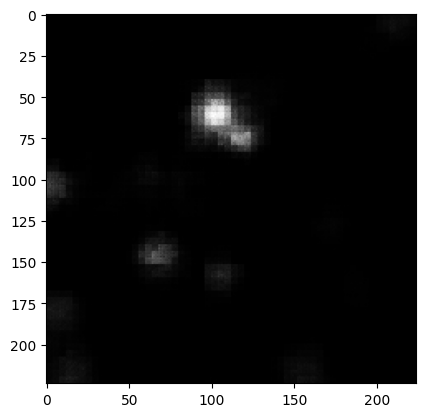

In [3]:
image_original = cv2.imread('results/prediction_0.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(image_original, cmap='gray')

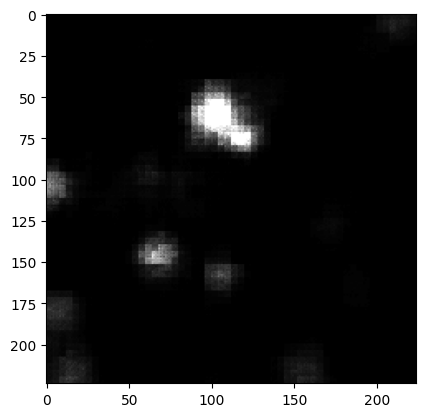

In [72]:
# apply smothing to the image
# using 2d guassian mask
image = image_original

def gaussian2d(sigma, size):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2)/(2*sigma**2)), (size, size))
    return kernel

def apply_gaussian_filter(image, sigma, size):
    kernel = gaussian2d(sigma, size)
    return cv2.filter2D(image, -1, kernel)

smothed_image = apply_gaussian_filter(image, 0.25, 10)

plt.imshow(smothed_image, cmap='gray')


/tmp/ipykernel_3497/2424711533.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  m1, m2 = np.sum(p1 * b1) / q1, np.sum(p2 * b2) / q2
/tmp/ipykernel_3497/2424711533.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  fn = v1 * q1 + v2 * q2


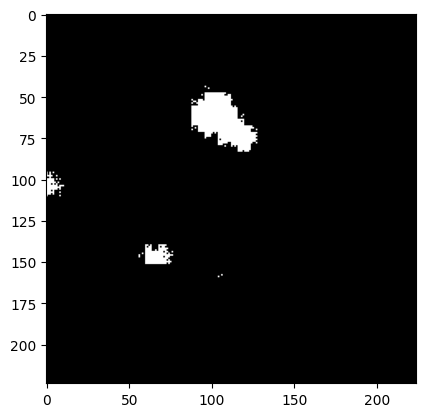

In [73]:
# apply binarisation to the image
# using otsu method

def otsu(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_norm = hist.ravel() / hist.max()
    Q = hist_norm.cumsum()
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    for i in range(1, 256):
        p1, p2 = np.hsplit(hist_norm, [i])
        q1, q2 = Q[i], Q[255] - Q[i]
        b1, b2 = np.hsplit(bins, [i])
        m1, m2 = np.sum(p1 * b1) / q1, np.sum(p2 * b2) / q2
        v1, v2 = np.sum(((b1 - m1) ** 2) * p1) / q1, np.sum(((b2 - m2) ** 2) * p2) / q2
        fn = v1 * q1 + v2 * q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
    return thresh


def apply_binarisation(image):
    thresh = otsu(image)
    return cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]

binarised_image = apply_binarisation(smothed_image)

plt.imshow(binarised_image, cmap='gray')

In [74]:
# # apply thresholding to the image

# def apply_thresholding(image, threshold):
#     return cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)[1]

# thresholded_image = apply_thresholding(smothed_image, 100)

# plt.imshow(thresholded_image, cmap='gray')

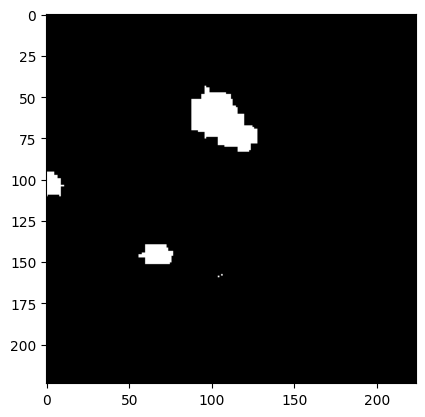

In [94]:
# apply morphological operations to the image

def apply_morphological_operations(image):
    kernel = np.ones((5,5), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

morphological_image = apply_morphological_operations(binarised_image)

plt.imshow(morphological_image, cmap='gray')

Number of blobs: 6


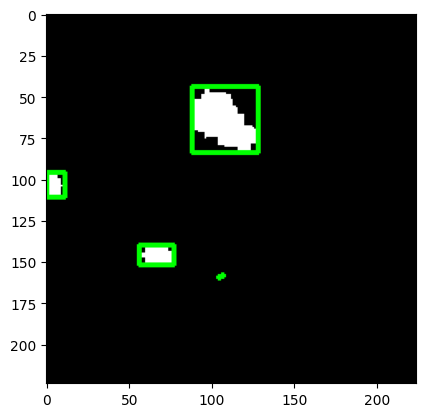

In [95]:
def get_blobs_stats(image):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    return num_labels, labels, stats, centroids

num_labels, labels, stats, centroids = get_blobs_stats(morphological_image)

print(f'Number of blobs: {num_labels}')

def draw_blobs(image, num_labels, labels, stats, centroids):
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return image

blobs_image = draw_blobs(cv2.cvtColor(morphological_image, cv2.COLOR_GRAY2BGR), num_labels, labels, stats, centroids)

plt.imshow(blobs_image)

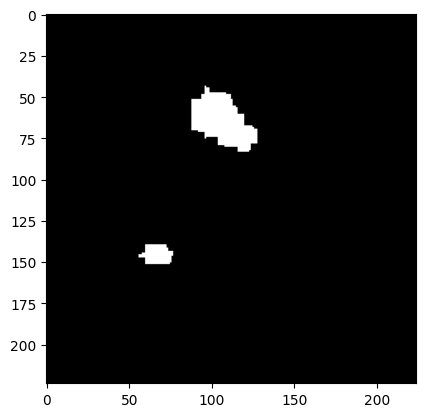

In [96]:
# remove the small blobs
def remove_small_blobs(image, num_labels, stats, min_area):
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area < min_area:
            image[labels == i] = 0
    return image

min_area = 150

filtered_image = remove_small_blobs(morphological_image.copy(), num_labels, stats, min_area)

plt.imshow(filtered_image, cmap='gray')


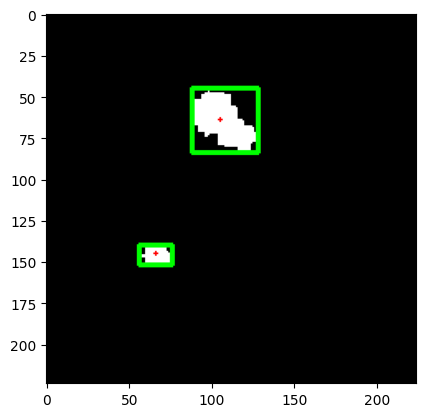

In [78]:
# draw the bounding boxes around the blobs and the centroids

num_labels, labels, stats, centroids = get_blobs_stats(filtered_image)

def draw_centroids(image, num_labels, centroids):
    for i in range(1, num_labels):
        x, y = centroids[i]
        cv2.circle(image, (int(x), int(y)), 1, (255, 0, 0), -1)
    return image


blobs_image = draw_blobs(cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2BGR), num_labels, labels, stats, centroids)

blobs_image = draw_centroids(blobs_image, num_labels, centroids)


plt.imshow(blobs_image)

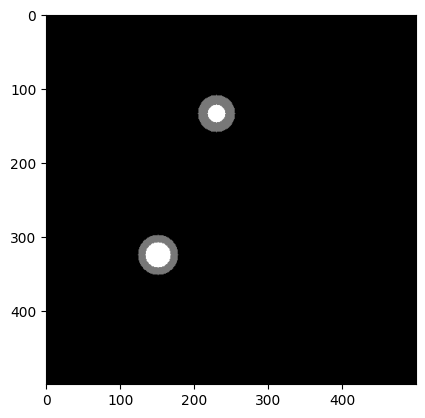

In [79]:
original_mask = cv2.imread('results/mask_0.png', cv2.IMREAD_GRAYSCALE)

# original_mask.shape

plt.imshow(original_mask, cmap='gray')

In [4]:
# apply all the pipeline in one function  

def pipeline(image):
    smothed_image = apply_gaussian_filter(image, 0.25, 10)
    # binarised_image = apply_binarisation(smothed_image)
    # morphological_image = apply_morphological_operations(binarised_image)
    # num_labels, labels, stats, centroids = get_blobs_stats(morphological_image)
    # filtered_image = remove_small_blobs(morphological_image.copy(), num_labels, stats, 150)
    # num_labels, labels, stats, centroids = get_blobs_stats(filtered_image)
    # blobs_image = draw_blobs(cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2BGR), num_labels, labels, stats, centroids)
    # blobs_image = draw_centroids(blobs_image, num_labels, centroids)
    return blobs_image

processed_image = pipeline(image_original)

plt.imshow(processed_image)

NameError: name 'apply_gaussian_filter' is not defined

In [81]:
# # detect the blobs in the image
# # using the connected components algorithm

# def connected_components(image):
#     num_labels, labels = cv2.connectedComponents(image)
#     return num_labels, labels

# def draw_blobs(image, labels):
#     image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
#     for label in range(1, labels.max() + 1):
#         mask = np.where(labels == label, 255, 0).astype(np.uint8)
#         contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
#     return image

# num_labels, labels = connected_components(morphological_image)


# blobs_image = draw_blobs(image, labels)


# plt.imshow(blobs_image)

In [82]:
# # draw the centroids on the image

# def draw_centroids(image, centroids):
#     image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
#     for centroid in centroids[1:]:
#         cv2.circle(image, tuple(map(int, centroid)), 2, (0, 0, 255), -1)
#     return image

# centroids_image = draw_centroids(morphological_image, centroids)

# plt.imshow(centroids_image)


# image stitching

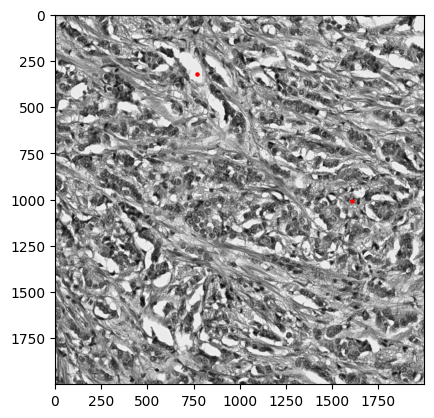

In [5]:
# we load and display the test image, mask, and centroids from the test directory

test_image = cv2.imread('test/test_image.png', cv2.IMREAD_GRAYSCALE)
test_mask = cv2.imread('test/test_mask.png', cv2.IMREAD_GRAYSCALE)
test_csv = csv.reader(open('test/test_centroid.csv', 'r'))

plt.imshow(test_image, cmap='gray')
# plt.imshow(test_mask, cmap='gray')
for row in test_csv:
    x, y = map(int, row)
    plt.scatter(x, y, c='red', s=5)



In [6]:
# we divide the test image into 500x500px patches 

def divide_image(image, size):
    patches = []
    for i in range(0, image.shape[0], size):
        for j in range(0, image.shape[1], size):
            patches.append(image[i:i+size, j:j+size])
    return patches

patches = divide_image(test_image, 500)
patches_mask = divide_image(test_mask, 500)

# we process the patches by resizing them to 224x224px
def process_image(image, size):
    processed_image = cv2.resize(image, (size, size))
    return processed_image

patches = [process_image(patch, 224) for patch in patches]
pathes_mask = [process_image(patch, 224) for patch in patches_mask]

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


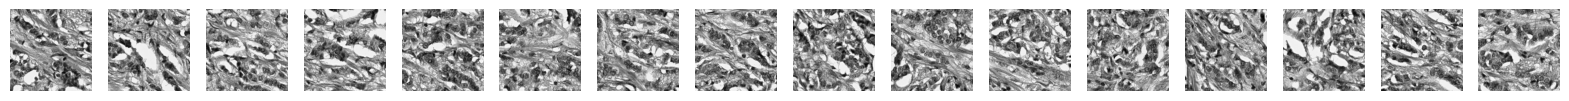

In [7]:
# display the patches
fig, ax = plt.subplots(1, len(patches), figsize=(20, 20))
for i, patch in enumerate(patches):
    print(patch.shape)
    ax[i].imshow(patch, cmap='gray')
    ax[i].axis('off')

(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)


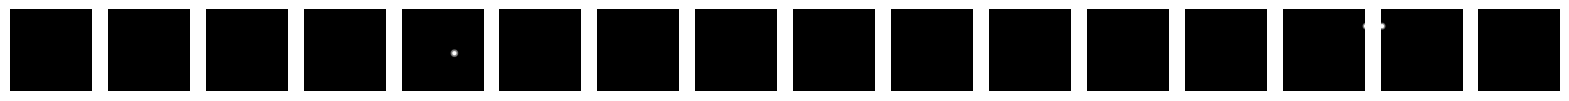

In [8]:
# display the patches
fig, ax = plt.subplots(1, len(patches_mask), figsize=(20, 20))
for i, patch in enumerate(patches_mask):
    print(patch.shape)
    ax[i].imshow(patch, cmap='gray')
    ax[i].axis('off')

In [9]:
# load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNet(224,224,1,32,1,3,4).to(device)
model.load_state_dict(torch.load("model/model v4.pth", map_location=device))

model.eval()

SwinUNet(
  (patch_embed): PatchEmbedding(
    (conv): Conv2d(1, 32, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Encoder(
    (enc_swin_blocks): ModuleList(
      (0): SwinBlock(
        (swtb1): SwinTransformerBlock(
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=32, out_features=96, bias=True)
            (proj): Linear(in_features=32, out_features=32, bias=True)
            (softmax): Softmax(dim=-1)
          )
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (0): Linear(in_features=32, out_features=128, bias=True)
            (1): GELU(approximate='none')
            (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=32, bias=True)
          )
        )
        (swtb2): SwinTransformerBlock(
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_aff

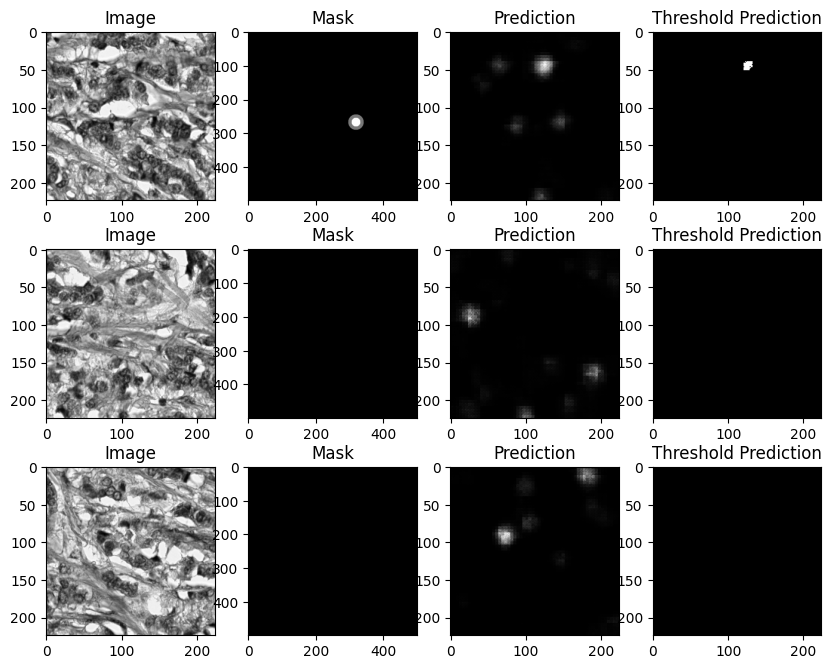

In [ ]:
# convert the patches to tensors
patches_tensor = [torch.tensor(patch).unsqueeze(0).unsqueeze(0).float().to(device) / 255 for patch in patches]
pathes_mask_tensor = [torch.tensor(patch).unsqueeze(0).unsqueeze(0).float().to(device) / 255 for patch in patches_mask]


j = 4

fig, ax = plt.subplots(3, 4, figsize=(10, 8))
with torch.no_grad():
  for i in range(3):  # Adjust the range to visualize more rows
    # Get a new batch of images and masks

    x_og, y_og = patches_tensor[j], pathes_mask_tensor[j]
    x = x_og[0]
    y = y_og[0]

    # Visualize image, mask, prediction, and thresholded prediction
    ax[i, 0].imshow(x.squeeze(0).squeeze(0), cmap='gray')
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(y.squeeze(0).squeeze(0), cmap='gray')
    ax[i, 1].set_title('Mask')

    x_og = x_og.to(device)
    out = model(x_og[:1])
    out = nn.Sigmoid()(out)
    out = out.squeeze(0).squeeze(0).cpu()

    # save the images
    cv2.imwrite(f"image_{i}.png", x.squeeze(0).squeeze(0).numpy()*255)
    cv2.imwrite(f"mask_{i}.png", y.squeeze(0).squeeze(0).numpy()*255)
    cv2.imwrite(f"prediction_{i}.png", (out.numpy()*255).astype(np.uint8))

    j+=1

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

# calculate the testing metrics